# tf.Datasets tutorial
+ https://www.tensorflow.org/guide/data

In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf 

In [3]:
import pathlib
import os
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

To construct a Dataset from data in memory, you can use tf.data.Dataset.from_tensors() or tf.data.Dataset.from_tensor_slices().  

Once in dataset form, you can transform it into a new Dataset by chaining method calls (e.g. .map(), .batch())  

Dataset object is a Python iterable.  

In [4]:
ds = tf.data.Dataset.from_tensor_slices([8, 3, 0, 2, 1])
ds

<TensorSliceDataset shapes: (), types: tf.int32>

In [6]:
for el in ds: 
    print(el, el.numpy())

tf.Tensor(8, shape=(), dtype=int32) 8
tf.Tensor(3, shape=(), dtype=int32) 3
tf.Tensor(0, shape=(), dtype=int32) 0
tf.Tensor(2, shape=(), dtype=int32) 2
tf.Tensor(1, shape=(), dtype=int32) 1


## Dataset

+ Contains elements that have the same (nested) strucure
+ individual components of the structure can be of any type representable by tf.TypeSpec 

Dataset.element_spec property allows you to inspec the type of each element component.  

In [8]:
ds.element_spec

TensorSpec(shape=(), dtype=tf.int32, name=None)

.map() and .transform() apply a function to each element  

In [11]:
ds1 = tf.data.Dataset.from_tensor_slices(
        tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32)
)
ds1

<TensorSliceDataset shapes: (10,), types: tf.int32>

In [12]:
for el in ds1: 
    print(el.numpy())

[4 4 7 7 3 5 5 3 9 3]
[6 3 9 1 9 6 6 4 2 1]
[4 9 8 6 3 7 9 5 6 6]
[4 6 8 5 2 5 9 6 5 8]


## testing with x-ray images 

In [70]:
def parse_function(filename): 
    """ Returns tuple.  (input, output) 
    
    Input is corrupted image.   
    Output is uncorrupted image.  Same filename. Diff folder. 
    """

    img_string = tf.io.read_file(filename) 
    img_decoded = tf.image.decode_png(img_string)  
    img_normed = img_decoded / 255

    fn_split = tf.strings.split(filename, '/')
    orig_filename = fn_split[0] + "/dataset128/" + fn_split[2]

    out_img_string = tf.io.read_file(orig_filename) 
    out_img_decoded = tf.image.decode_png(out_img_string)  
    out_img_normed = out_img_decoded / 255

    return img_normed, out_img_normed


In [71]:
inp, out = parse_function('data/dataset128-easy-gaus/IM-0001-0001.jpeg')

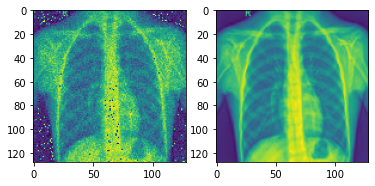

In [72]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(np.squeeze(inp))
ax[1].imshow(np.squeeze(out))

+ [x] `parse_image` function tested on single image.  

Now build dataset object with parse function. 

In [73]:
def create_dataset(filenames, SHUFFLE_BUFFER_SIZE, 
                  AUTOTUNE, BATCH_SIZE): 
    """ Init a tf.Dataset 
    """   
    
    dataset = tf.data.Dataset.from_tensor_slices((filenames))
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [82]:
# get list of all files in the input directory 
input_directory = 'data/dataset128-easy-gaus/'

filenames = os.listdir(os.path.abspath(input_directory)) 
filenames = [input_directory + fn for fn in filenames]

In [83]:
BATCH_SIZE = 32 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 8    # Shuffle the training data by a chunck of this many observations

In [84]:
train_ds = create_dataset(filenames, SHUFFLE_BUFFER_SIZE=SHUFFLE_BUFFER_SIZE,
                          BATCH_SIZE=BATCH_SIZE, AUTOTUNE=AUTOTUNE)

In [86]:
for inp, out in train_ds.take(1):
    print(inp.shape)
    

(32, 128, 128, 1)


+ [x] yeet.  dataset is serving properly 

Confirming with a vis 

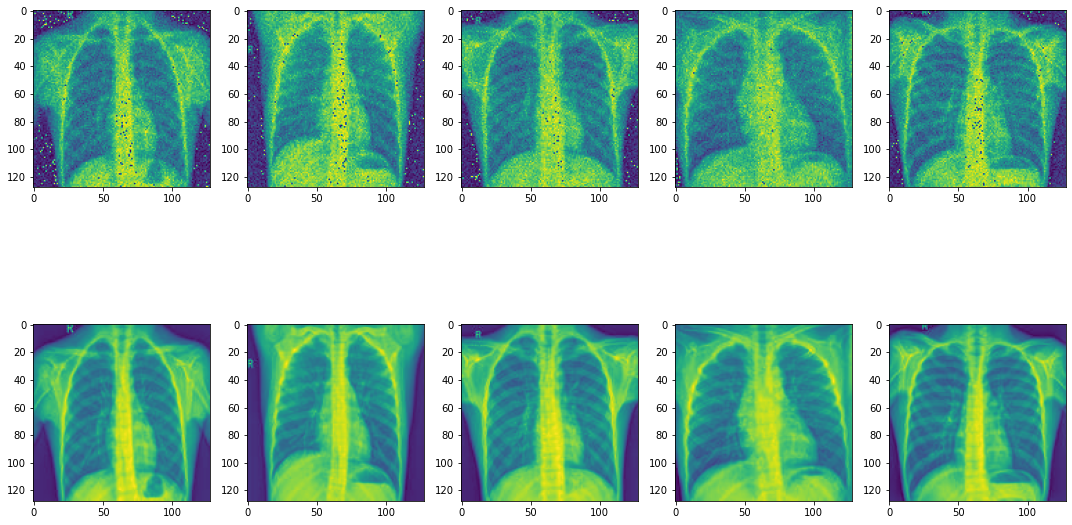

In [95]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))

for inp, out in train_ds.take(1): 
    
    for i in range(5): 
        inp_img = np.squeeze(inp[i, :, :, :])
        out_img = np.squeeze(out[i, :, :, :])

        axes[0, i].imshow(inp_img)
        axes[1, i].imshow(out_img)
        
plt.tight_layout()

+ [x] clean and push to utils.py 
+ [ ] separate out a validation set   